In [15]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path

In [2]:
tf.__version__

'2.0.0-rc1'

In [3]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
czek = np.load('snaps_R/snaps_T042_R01.npy')
print(czek.shape)
czek = np.reshape(czek,(502,100*100))
print(czek.shape)

(5020000,)
(502, 10000)


In [4]:
#universal regardless of snapshot size
N_PHASES = 3
HIDDEN_NODES = 32
num_of_snaps_in_file = 502

In [5]:
#universal regardless of snapshot size
def model(X):
    """Creates a neural network with input X"""
    #hidden layer with 100 neurons, ReLU activated
    X = tf.layers.dense(inputs=X, units=HIDDEN_NODES, activation=tf.nn.relu)
    #output layer with 3 neurons (as there are 3 classes to classify, softmax activated)
    X = tf.layers.dense(inputs = X, units = N_PHASES, activation=tf.nn.softmax)
    return X    

def loss_fun(output,labels):
    """Cross-entropy loss:
    labels - a tensor of labels, shape ?x1
    output - neural network softmax output, shape ?x3"""
    onehot_labels = tf.one_hot(indices=labels, depth=N_PHASES)
    probability_right = tf.reduce_sum(tf.multiply(onehot_labels, output), axis=1)
    cnst=tf.constant(0.00000001)#to avoid log(0)
    return -tf.reduce_mean(tf.log(cnst + probability_right))

def accuracy(output,labels):
    """Accuracy, i.e. what is the fraction of correctly labeled examples
    labels - a tensor of labels, shape ?x1
    output - neural network softmax output, shape ?x3
    """
    argmax = tf.cast(tf.argmax(output, 1), dtype=tf.int32 )
    equals = tf.cast (tf.equal(argmax, labels), dtype=tf.float32)
    return tf.reduce_mean(equals)

In [6]:
visible_nodes = 100*100

In [24]:
#get training and validation data (80% training, 20% validation)

numbers = ['001','30','01','6','8','10','16','20','24']
filenames = ['snaps_R/snaps_T042_R'+str(number)+'.npy' for number in numbers]

examples = [np.reshape(np.load(filename),(num_of_snaps_in_file,visible_nodes)) for filename in filenames]
examples = np.concatenate(examples, axis = 0)
print(np.shape(examples))

ex_per_phase = examples.shape[0]/N_PHASES #examples per phase
labels = np.concatenate([np.repeat(0, ex_per_phase), np.repeat(1, ex_per_phase),  np.repeat(2, ex_per_phase)], axis=0)

#randomly permute the data and assign 80% to training with 20% to validation
perm = np.random.permutation(examples.shape[0])
labels, examples = labels[perm], examples[perm]
num_training = int(0.8*examples.shape[0])
x_trn, x_val = examples[:num_training], examples[num_training:]
y_trn, y_val = labels[:num_training], labels[num_training:]

#placeholders for X (input) and Y (output) of the neural network and saver to save the network to a file when needed
Xph = tf.placeholder(tf.float32, shape=[None, visible_nodes], name="X_ph")
Yph = tf.placeholder(tf.int32, shape=[None], name="Y_ph")

(4518, 10000)


In [25]:
#create the network, test if before any training accuracy is around ~33%
#create a Saver() for further saving of trained network
neural_net = model(Xph)
loss = loss_fun(neural_net, Yph)
acc = accuracy(neural_net, Yph)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    acc_tr = sess.run(acc, feed_dict={Xph:x_trn, Yph:y_trn})
    acc_val = sess.run(acc, feed_dict={Xph:x_val, Yph:y_val})
    loss_tr = sess.run(loss, feed_dict={Xph:x_trn, Yph:y_trn})
    loss_val = sess.run(loss, feed_dict={Xph:x_val, Yph:y_val})
    print("Check before any training. Acc traninig set:", acc_tr, "Acc validation set:", acc_val,
         "Loss traninig set:", loss_tr, "Loss validation set:", loss_val)
    
saver = tf.train.Saver()

Check before any training. Acc traninig set: 0.24405092 Acc validation set: 0.23230088 Loss traninig set: 1.2302978 Loss validation set: 1.2299501


In [26]:
#train the network
num_epochs = 25
minibatch_size = 25
num_batches = int(np.floor(labels.shape[0]/minibatch_size))
train_operation = tf.train.AdamOptimizer(0.0001).minimize(loss)

loss_fun_tr =[]
loss_fun_val =[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        #display training-relevant quantities every 2nd epoch
        if (i%2==0):
            acc_tr = sess.run(acc, feed_dict = {Xph:x_trn, Yph:y_trn})
            acc_val = sess.run(acc, feed_dict = {Xph:x_val, Yph:y_val})
            loss_tr = sess.run(loss, feed_dict = {Xph:x_trn, Yph:y_trn})
            loss_val = sess.run(loss, feed_dict = {Xph:x_val, Yph:y_val})
            print("==========\nEpoch",i,"\nacc train", acc_tr, "acc val",acc_val
                  , "\nloss train",loss_tr, "loss val",loss_val)
            loss_fun_tr.append(loss_tr)
            loss_fun_val.append(loss_val)            
        #perform the training operation
        for j in range(num_batches):
            x_batch = x_trn[j*minibatch_size:(j+1)*minibatch_size]
            y_batch = y_trn[j*minibatch_size:(j+1)*minibatch_size]
            sess.run(train_operation, feed_dict = {Xph:x_batch, Yph:y_batch})
        #permute to get different minibatches at next epoch
        perm = np.random.permutation(y_trn.shape[0])
        x_trn, y_trn = x_trn[perm], y_trn[perm]
     #after trainig save the model
    saver.save(sess, 'net-after-'+str(num_epochs)+'-epochs')
        
        

Epoch 0 
acc train 0.3702269 acc val 0.38053098 
loss train 1.2137079 loss val 1.2324243
Epoch 2 
acc train 0.89734364 acc val 0.8915929 
loss train 0.2614381 loss val 0.28191277
Epoch 4 
acc train 0.9800775 acc val 0.9579646 
loss train 0.06219765 loss val 0.08975205
Epoch 6 
acc train 0.9997233 acc val 0.99557525 
loss train 0.019450875 loss val 0.034903433
Epoch 8 
acc train 1.0 acc val 0.9977876 
loss train 0.010819735 loss val 0.02474162
Epoch 10 
acc train 1.0 acc val 1.0 
loss train 0.011278113 loss val 0.023661116
Epoch 12 
acc train 1.0 acc val 0.9988938 
loss train 0.0045973724 loss val 0.015012889
Epoch 14 
acc train 1.0 acc val 1.0 
loss train 0.0034586997 loss val 0.011020673
Epoch 16 
acc train 1.0 acc val 0.9977876 
loss train 0.00303753 loss val 0.014529874
Epoch 18 
acc train 1.0 acc val 1.0 
loss train 0.0019745543 loss val 0.009832634
Epoch 20 
acc train 1.0 acc val 1.0 
loss train 0.0013190312 loss val 0.0068138186
Epoch 22 
acc train 1.0 acc val 1.0 
loss train 0.0

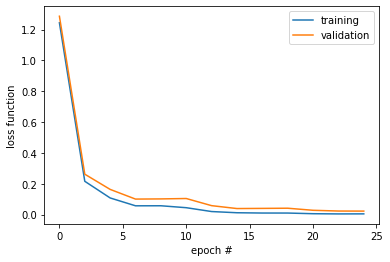

In [11]:
plt.plot(np.arange(0,num_epochs,2),loss_fun_tr,label='training');
plt.plot(np.arange(0,num_epochs,2),loss_fun_val,label='validation');
plt.xlabel('epoch #')
plt.ylabel('loss function')
plt.legend(loc=1)

plt.savefig('los_function_T042.png')

In [27]:
#Use the previously trained neural net to classify all examples
#For each of the points, check how many of the  snapshots are classified to each phases 0, 1, 2
#i. e. print how many occurences of each phase there are
shear_values = ['001','003','005','008','01','02','03','05','1','2','3','4','5', '6','7', '8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'] #
temps = ['042', '045','055']
res = {}
with tf.Session() as sess:
    saver.restore(sess,'net-after-'+str(num_epochs)+'-epochs')
    for j in temps:
        res[j] = {}
        for i in shear_values:
            snap = 'snaps_R/snaps_T'+str(j)+'_R'+str(i)+'.npy'
            if path.isfile(snap):
                res[j].update({i:''})
                x_current = np.load(snap)
                x_current = np.reshape(x_current,(num_of_snaps_in_file,visible_nodes))
                out = sess.run(neural_net, feed_dict = {Xph: x_current})
                argmax = np.argmax(out,axis=1)
                unique, counts = np.unique(argmax, return_counts = True)
                counts_to_present = dict(zip(unique, counts/num_of_snaps_in_file))
                res[j][i] = counts_to_present

INFO:tensorflow:Restoring parameters from net-after-25-epochs


In [202]:

#res.keys()
#res.values()
#print(res.get('01').values())
res

{'02': {1: 1.0},
 '03': {1: 1.0},
 '05': {0: 0.08764940239043825, 1: 0.9123505976095617},
 '1': {0: 0.703187250996016, 1: 0.2968127490039841},
 '2': {0: 0.47410358565737054, 1: 0.5258964143426295},
 '4': {0: 1.0},
 '6': {0: 1.0},
 '8': {0: 1.0},
 '10': {0: 1.0},
 '12': {1: 1.0},
 '14': {0: 0.05179282868525897, 1: 0.9482071713147411},
 '16': {1: 1.0},
 '18': {1: 1.0},
 '20': {0: 0.09760956175298804, 1: 0.9023904382470119},
 '22': {0: 0.6633466135458167, 1: 0.33665338645418325},
 '24': {1: 1.0},
 '26': {1: 1.0}}

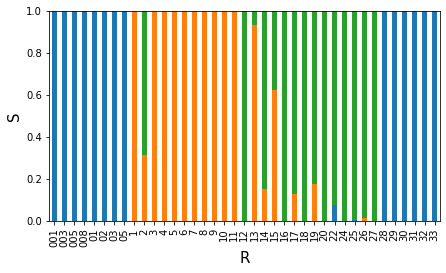

<Figure size 432x288 with 0 Axes>

In [42]:
T = '042'
pd.DataFrame(res[T]).T.plot(kind='bar',stacked=True, figsize=(7,4), legend = False)
plt.xlabel('R',fontsize=15)
plt.ylabel('S',fontsize=15)
#plt.title("Dense Network, T = "+str(T),fontsize=20)
plt.ylim(0,1)
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('T042_diagram_3phases.png')
plt.savefig('T042_diagram_3phases.svg')
plt.savefig('T042_diagram_3phases.eps')

plt.show()
plt.draw()

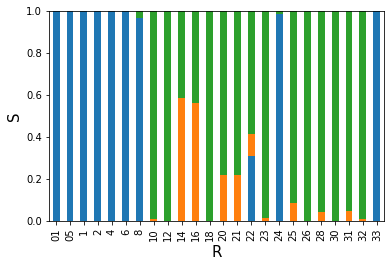

<Figure size 432x288 with 0 Axes>

In [43]:
T = '055'
pd.DataFrame(res[T]).T.plot(kind='bar',stacked=True, figsize=(6,4), legend = False)
plt.xlabel('R',fontsize=15)
plt.ylabel('S',fontsize=15)
#plt.title("Dense Network, T = "+str(T),fontsize=20)
plt.ylim(0,1)
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('T055_diagram_3phases.png')
plt.savefig('T055_diagram_3phases.svg')
plt.savefig('T055_diagram_3phases.eps')

plt.show()
plt.draw()